In [2]:
%matplotlib nbagg

In [3]:
import numpy as np
from ncempy.io.dm import fileDM
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [4]:
from libertem_holo.base.reconstr import (
    aperture_function, freq_array, get_aperture, reconstruct_frame,
    estimate_sideband_position, estimate_sideband_size
)
from libertem_holo.base.filters import highpass, exclusion_mask, clipped, remove_dead_pixels

In [26]:
from libertem_holo.base.filters import phase_unwrap

In [5]:
with fileDM("/home/alex/Data/dm/alpha-50_obj.dm3") as f:
    data = f.getDataset(0)

In [6]:
img = data['data'][0]

<IPython.core.display.Javascript object>


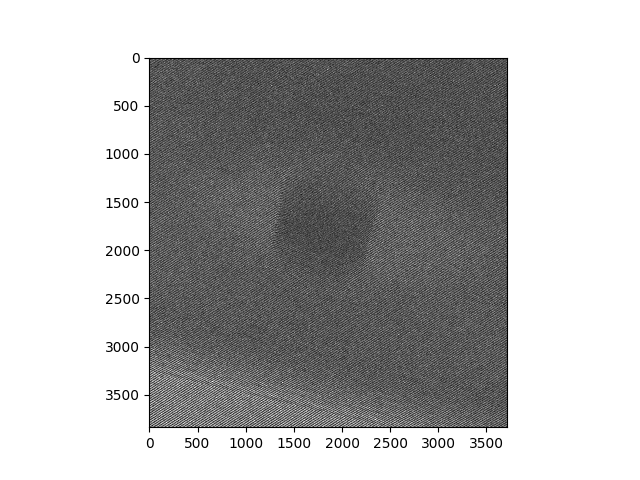

In [7]:
plt.figure()
plt.imshow(np.abs(img), vmax=np.max(clipped(img)), interpolation='nearest', cmap='gray')

<IPython.core.display.Javascript object>


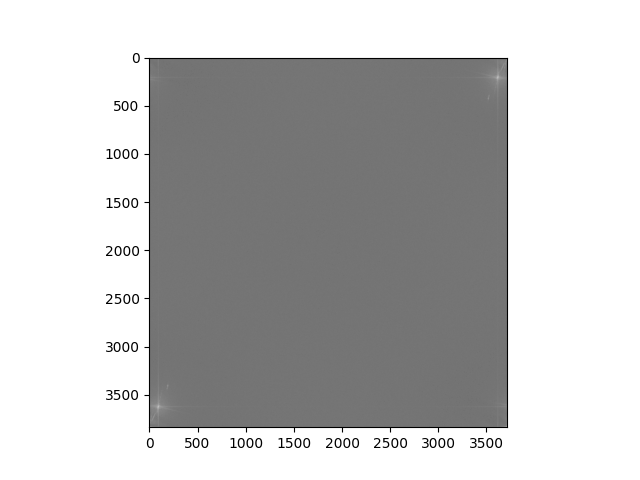

In [13]:
plt.figure()
plt.imshow(np.abs(np.fft.ifft2(img)), norm=LogNorm(), cmap='gray')

In [9]:
sb_position = estimate_sideband_position(img, holo_sampling=(1, 1))

In [10]:
sb_size = estimate_sideband_size(sb_position, img.shape, sb_size_ratio=0.5)

In [11]:
sb_size, sb_position

(115.90621208546158, array([ 211, 3614]))

In [12]:
out_shape = (256, 256)
slice_fft, aperture = get_aperture(out_shape=out_shape, sb_size=sb_size, sb_smoothness=15, sig_shape=img.shape)

In [14]:
data['data'].shape

(20, 3838, 3710)

In [16]:
wavs = np.zeros((data['data'].shape[0],) + out_shape, dtype=np.complex128)

In [18]:
for idx, img in enumerate(data['data']):
    print(img.shape)
    wav = reconstruct_frame(img, sb_pos=sb_position, slice_fft=slice_fft, aperture=aperture)
    wavs[idx] = wav

(3838, 3710)
(3838, 3710)
(3838, 3710)
(3838, 3710)
(3838, 3710)
(3838, 3710)
(3838, 3710)
(3838, 3710)
(3838, 3710)
(3838, 3710)
(3838, 3710)
(3838, 3710)
(3838, 3710)
(3838, 3710)
(3838, 3710)
(3838, 3710)
(3838, 3710)
(3838, 3710)
(3838, 3710)
(3838, 3710)


In [21]:
import hyperspy.api as hs

In [31]:
wavs_unwrapped = np.zeros(wavs.shape, dtype=np.float64)

In [32]:
for idx, img in enumerate(wavs):
    wavs_unwrapped[idx] = phase_unwrap(img)

<IPython.core.display.Javascript object>


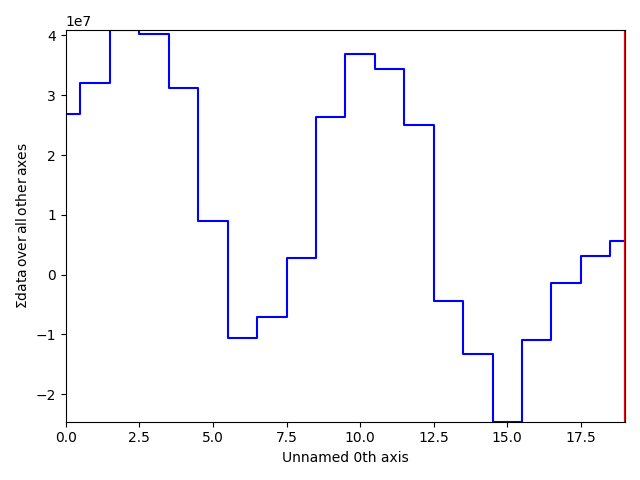

<IPython.core.display.Javascript object>


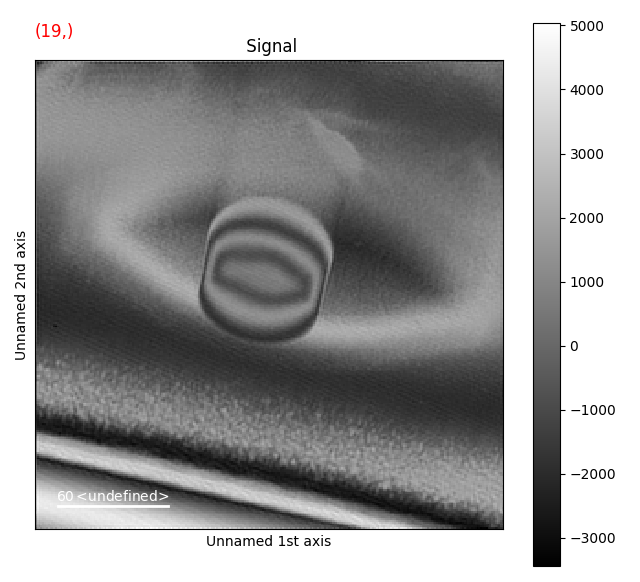

In [162]:
s_real = hs.signals.Signal2D(wavs.real)
s_real.plot()

<IPython.core.display.Javascript object>


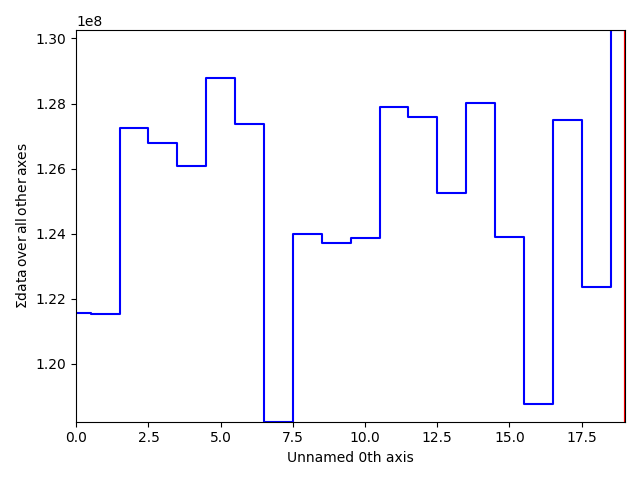

<IPython.core.display.Javascript object>


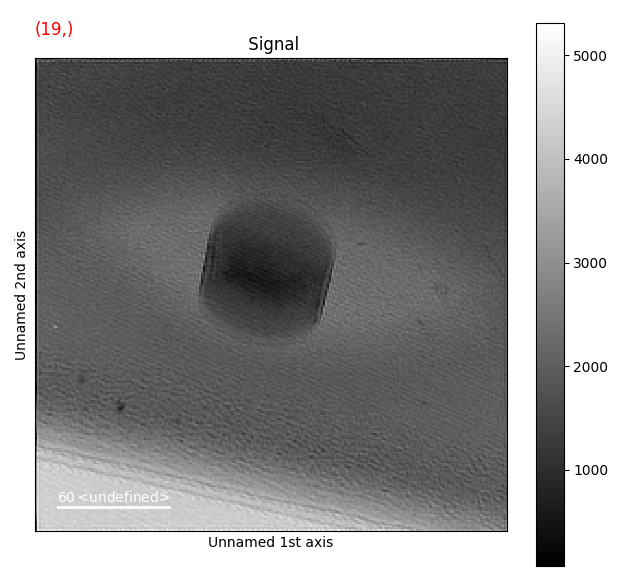

In [161]:
s_wavs = hs.signals.Signal2D(np.abs(wavs))
s_wavs.plot()

In [35]:
s = hs.signals.Signal2D(wavs_unwrapped)

<IPython.core.display.Javascript object>


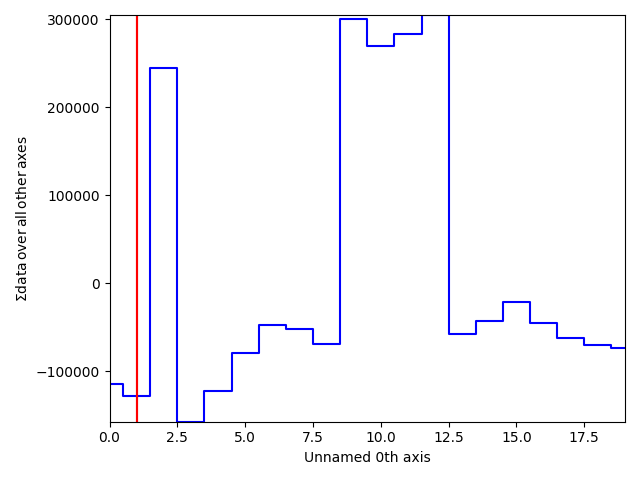

<IPython.core.display.Javascript object>


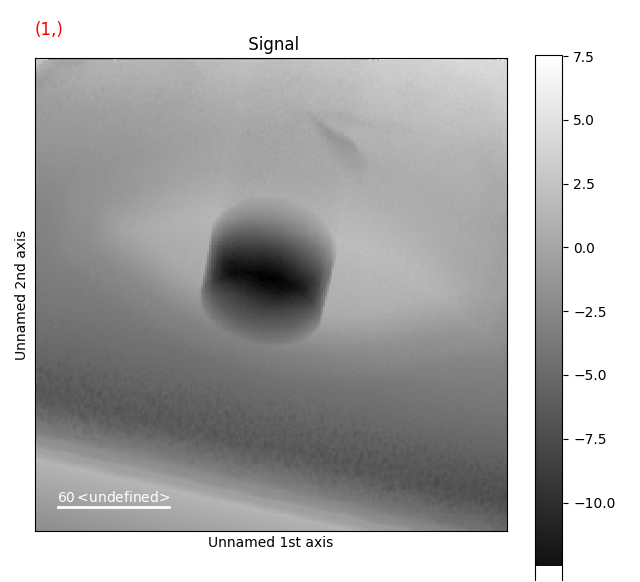

In [36]:
s.plot()

<IPython.core.display.Javascript object>


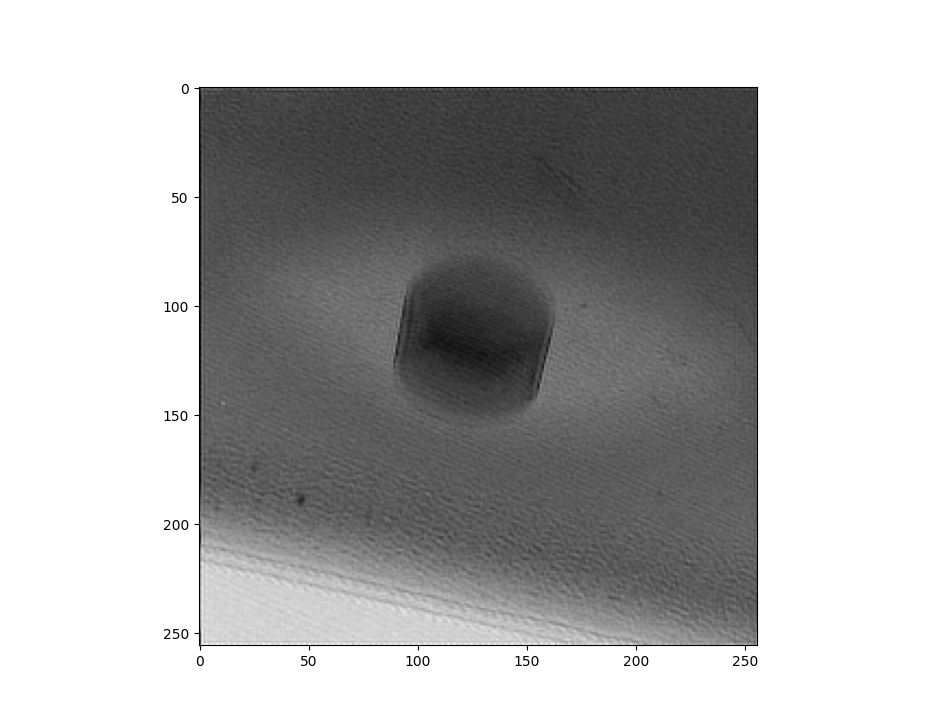

In [54]:
plt.figure()
plt.imshow(np.abs(wavs[0]), cmap='gray')

In [37]:
from skimage.registration import phase_cross_correlation

In [61]:
center_of_the_image = np.zeros(out_shape, dtype=np.bool)
center_of_the_image[50:175, 70:175] = 1

<IPython.core.display.Javascript object>


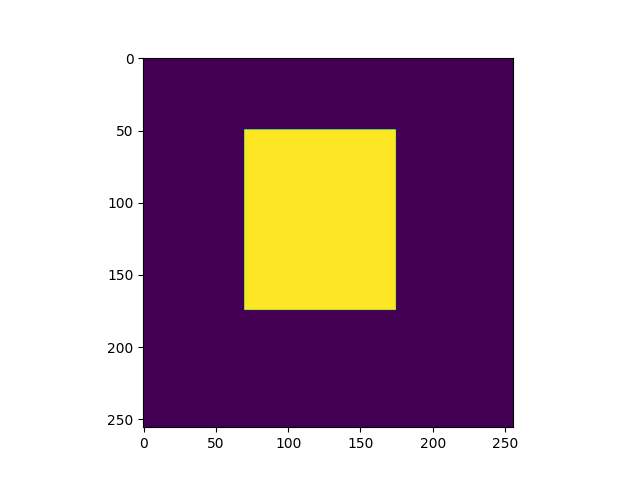

In [62]:
plt.figure()
plt.imshow(center_of_the_image)

In [64]:
%pdb on

Automatic pdb calling has been turned ON


In [86]:
import numba
from numpy import fft
import os

if os.getenv('NUMBA_DISABLE_JIT'):
    def to_fixed_tuple(arr, l):
        return tuple(arr)
else:
    from numba.np.unsafe.ndarray import to_fixed_tuple



@numba.njit
def center_of_mass(arr):
    r_y = r_x = np.float32(0)
    for y in range(arr.shape[0]):
        for x in range(arr.shape[1]):
            r_y += np.float32(arr[y, x]*y)
            r_x += np.float32(arr[y, x]*x)
    s = arr.sum()
    return (np.float32(r_y/s), np.float32(r_x/s))


@numba.njit
def refine_center(center, r, corrmap):
    (y, x) = center
    s = corrmap.shape
    r = min(r, y, x, s[0] - y - 1, s[1] - x - 1)
    if r <= 0:
        return (np.float32(y), np.float32(x))
    else:
        # FIXME See and compare with Extension of Phase Correlation to Subpixel Registration
        # Hassan Foroosh
        # That one or a close/similar/cited one
        cutout = corrmap[y-r:y+r+1, x-r:x+r+1]
        m = np.min(cutout)
        ry, rx = center_of_mass(cutout - m)
        refined_y = y + ry - r
        refined_x = x + rx - r
        # print(y, x, refined_y, refined_x, "\n", cutout)
        return (np.float32(refined_y), np.float32(refined_x))


@numba.njit
def peak_elevation(center, corrmap, height, r_min=1.5, r_max=np.float('inf')):
    '''
    Return the slope of the tightest cone around :code:`center` with height :code:`height`
    that touches :code:`corrmap` between :code:`r_min` and :code:`r_max`.

    The correlation of two disks -- mask and perfect diffraction spot -- has the shape of a cone.
    The function's return value correlates with the quality of a correlation. Higher slope
    means a strong peak and
    no side maxima, while weak signal or side maxima lead to a flatter slope.

    Parameters
    ----------
    center : numpy.ndarray
        (y, x) coordinates of the center within the :code:`corrmap`
    corrmap : numpy.ndarray
        Correlation map
    height : float
        The height is provided as a parameter since center can be float values from refinement
        and the height value is conveniently available from the calling function.
    r_min : float, optional
        Masks out a small local plateau around the peak that would distort and dominate
        the calculation.
    r_max : float, optional
        Mask out neighboring peaks if a large area with several legitimate peaks is
        correlated.

    Returns
    -------
    elevation : float
        Elevation of the tightest cone that fits the correlation map within the given
        parameter range.
    '''
    peak_y, peak_x = center
    (size_y, size_x) = corrmap.shape
    result = np.float32(np.inf)

    for y in range(size_y):
        for x in range(size_x):
            dist = np.sqrt((y - peak_y)**2 + (x - peak_x)**2)
            if (dist >= r_min) and (dist < r_max):
                result = min((result, np.float32((height - corrmap[y, x]) / dist)))
    return max(0, result)


def do_correlations(template, crop_parts):
    '''
    Calculate the correlation of the pre-calculated template with a stack
    of cropped peaks using fast correlation.

    Parameters
    ----------
    template : numpy.ndarray
        Real Fourier transform of the correlation pattern.
        The source pattern should have the same size as the cropped parts. Please note that
        the real Fourier transform (fft.rfft2) of the source pattern has a different shape!
    crop_parts : numpy.ndarray
        Stack of peaks cropped from the frame.

    Returns
    -------
    corrs : numpy.ndarray
        Correlation of the correlation pattern and the peaks.
    '''
    spec_parts = fft.rfft2(crop_parts)
    corrspecs = template * spec_parts
    corrs = fft.fftshift(fft.irfft2(corrspecs), axes=(-1, -2))
    return corrs


@numba.njit
def unravel_index(index, shape):
    sizes = np.zeros(len(shape), dtype=np.int64)
    result = np.zeros(len(shape), dtype=np.int64)
    sizes[-1] = 1
    for i in range(len(shape) - 2, -1, -1):
        sizes[i] = sizes[i + 1] * shape[i + 1]
    remainder = index
    for i in range(len(shape)):
        result[i] = remainder // sizes[i]
        remainder %= sizes[i]
    return to_fixed_tuple(result, len(shape))

In [134]:
toto = np.linspace(0, 1, 256*256).reshape(256, 256)
toto_temp = fft.rfft2(toto)

<IPython.core.display.Javascript object>


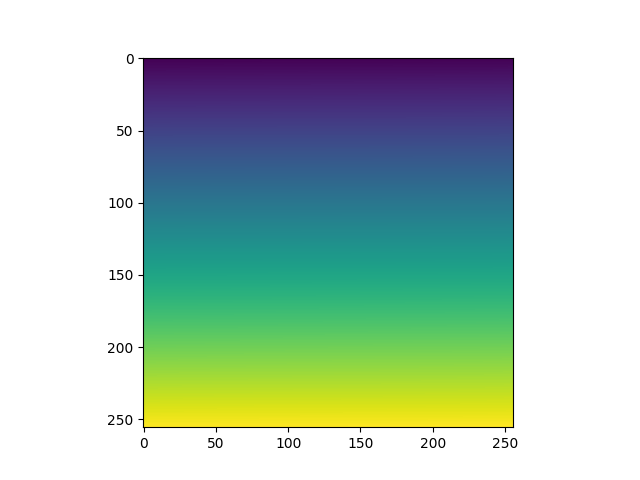

In [135]:
plt.figure()
plt.imshow(toto)

In [137]:
corrmap_toto = do_correlations(toto_temp, toto)

<IPython.core.display.Javascript object>


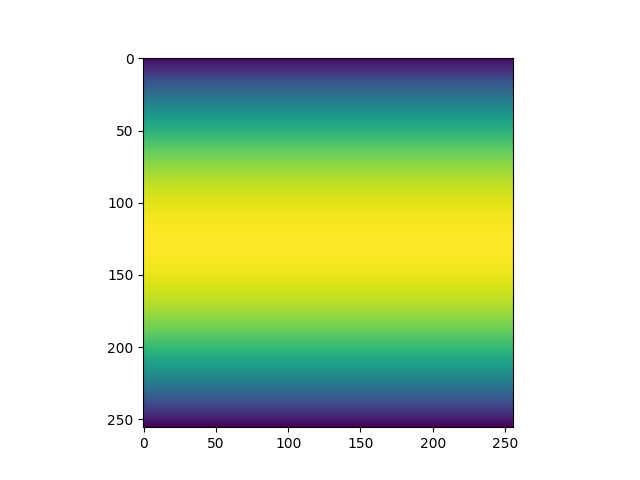

In [140]:
plt.figure()
plt.imshow(np.fft.fftshift(corrmap_toto))

In [143]:
center = np.unravel_index(np.argmax(np.fft.fftshift(corrmap_toto)), corrmap_toto.shape)

In [144]:
center

(127, 127)

In [151]:
template = np.fft.rfft2(np.abs(wavs[0]))

In [152]:
corrmap = do_correlations(template, np.abs(wavs[1])).squeeze()

<IPython.core.display.Javascript object>


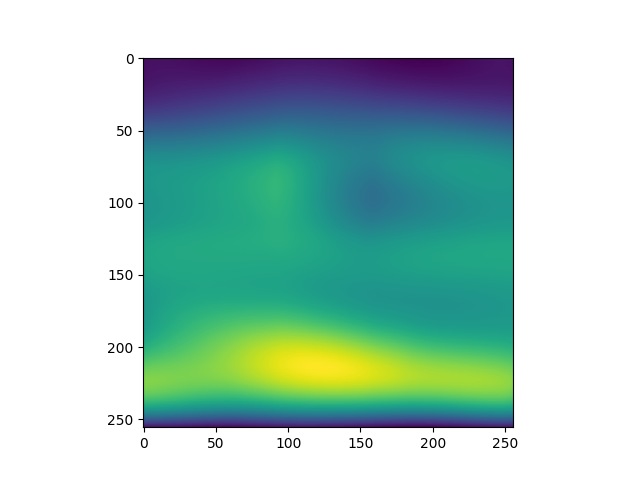

In [154]:
plt.figure()
plt.imshow(np.abs(np.fft.fftshift(corrmap)))

In [155]:
center = np.unravel_index(np.argmax(corrmap), corrmap.shape)
print(center)
refined = np.array(refine_center(center, 2, corrmap), dtype=np.float32)
center, refined

(86, 253)


((86, 253), array([ 86.16913, 252.82404], dtype=float32))

In [218]:
from scipy.ndimage import shift, fourier_shift
from scipy.ndimage import gaussian_filter

In [267]:
# img_1 = np.random.randn(256, 256)
img_1 = np.abs(wavs[0])

In [273]:
offset = (-0.456789, 7)
# img_2 = np.fft.ifftn(fourier_shift(np.fft.fftn(img_1), offset))
img_2 = shift(img_1, offset)

<IPython.core.display.Javascript object>


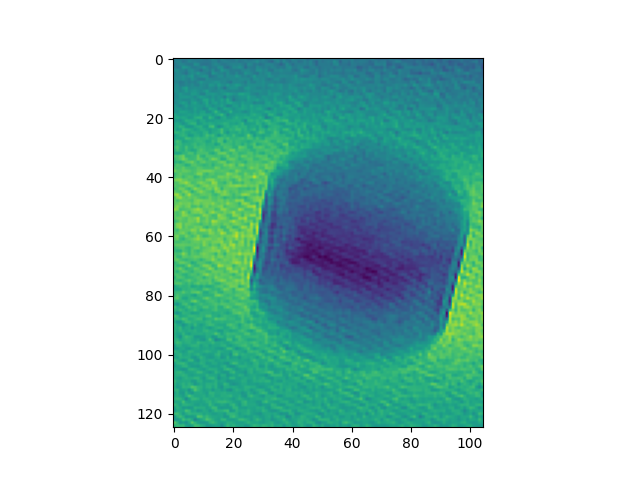

In [275]:
plt.figure()
plt.imshow(img_2[50:175, 70:175])

<IPython.core.display.Javascript object>


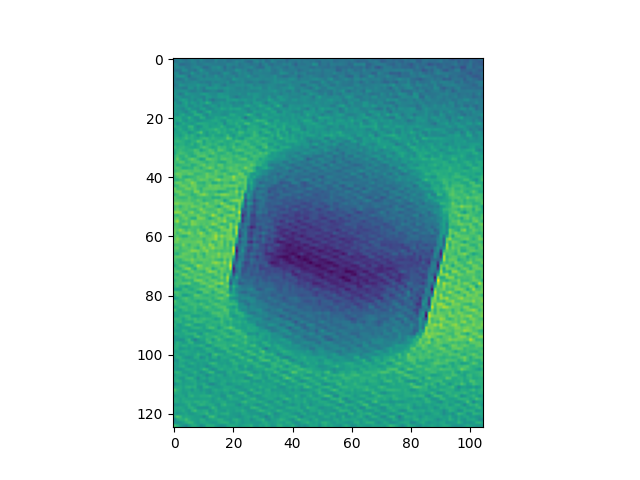

In [276]:
plt.figure()
plt.imshow(img_1[50:175, 70:175])

In [279]:
phase_cross_correlation(img_1, img_2, upsample_factor=10, moving_mask=center_of_the_image, reference_mask=center_of_the_image, space='real')

array([ 0., -7.])

In [282]:
for idx, img in enumerate(wavs):
    results = phase_cross_correlation(
        reference_image=np.abs(wavs[0]),
        moving_image=np.abs(img),
        upsample_factor=1000,
        # moving_mask=center_of_the_image,
        # reference_mask=center_of_the_image,
        space='fourier',
    )
    print(results)

(array([0., 0.]), 2.9802322387695312e-08, -0.0)
(array([0., 0.]), 0.047213905238282554, -0.0)
(array([0., 0.]), 0.05483725376410613, -0.0)
(array([0., 0.]), 0.0569060569828771, -0.0)
(array([0., 0.]), 0.05461205189520939, -0.0)
(array([0., 0.]), 0.059062024659596764, -0.0)
(array([0., 0.]), 0.06368665137239249, -0.0)
(array([0., 0.]), 0.06880367721153308, -0.0)
(array([0., 0.]), 0.07056459262743518, -0.0)
(array([0., 0.]), 0.07311735616887133, -0.0)
(array([0., 0.]), 0.0757514233502487, -0.0)
(array([0., 0.]), 0.07326918174256494, -0.0)
(array([0., 0.]), 0.0718744202094948, -0.0)
(array([0., 0.]), 0.07292879788642508, -0.0)
(array([0., 0.]), 0.0675013460837357, -0.0)
(array([0., 0.]), 0.06249451334326453, -0.0)
(array([0., 0.]), 0.056215117158219544, -0.0)
(array([0., 0.]), 0.04428115867589865, -0.0)
(array([0., 0.]), 0.04985804239155178, -0.0)
(array([0., 0.]), 0.06312416786119716, -0.0)
